### At this point, I'm adding the sigmoid reparameterization trick for center weight too, to avoid the absorbing boundary problem

In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.l

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


### Load receptive fields

In [12]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [13]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

David's 1721 receptive field dataset

In [14]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

### Remove duplicates

In [16]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

249it [00:02, 112.21it/s]
2it [00:00, 13378.96it/s]
321it [00:03, 90.77it/s] 
253it [00:02, 114.14it/s]
2it [00:00, 14794.72it/s]
2it [00:00, 13464.86it/s]
28it [00:00, 1031.82it/s]
126it [00:00, 233.54it/s]
772it [00:20, 37.48it/s] 


In [23]:
sum([len(receptive_fields[k]) for k in receptive_fields.keys()]) - sum([len(receptive_fields[k]) for k in ['horizontal',
                                                                                                           'amacrine',
                                                                                                          'bipolar']])

1382

### Compute projective fields

In [24]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [25]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [26]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [27]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [28]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


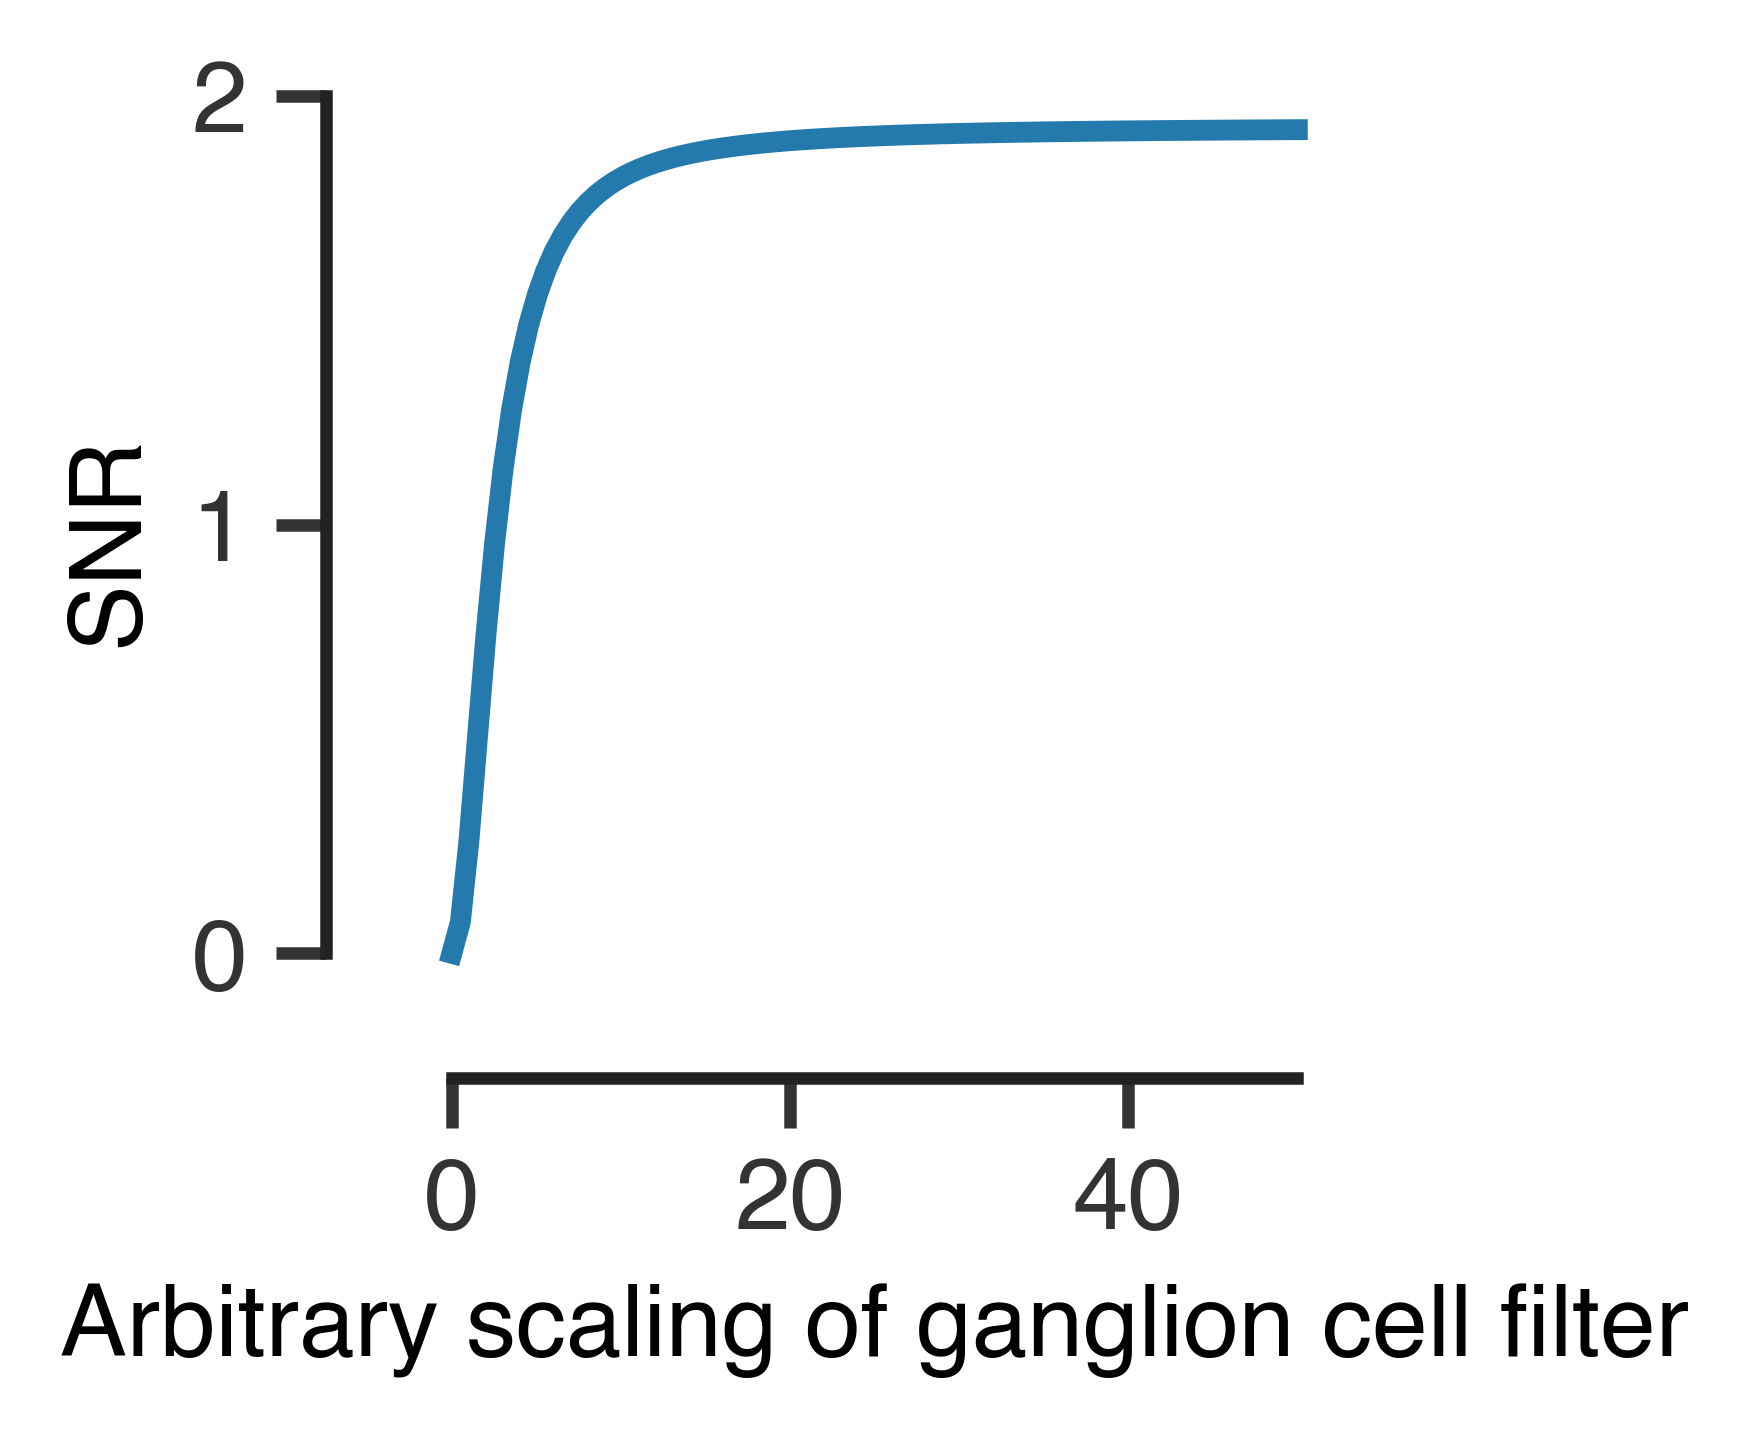

In [29]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [30]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124689452


### Ideal filter

In [31]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.04940562348e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [32]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

### Just a simple difference of Gaussians fit to get the initialization point for center width, and the mean center width to find the ideal fit

Get center widths for each celltype

In [33]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [34]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [35]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

217it [00:44,  5.25it/s]
148it [00:56,  2.04it/s]
772it [01:35,  8.12it/s]
58it [00:13,  5.21it/s]
28it [00:10,  1.09it/s]
159it [00:26,  8.37it/s]


In [36]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 3 in fast_off_sensitizing
couldn't fit 13 in slow_off
couldn't fit 4 in fast_off_adapting
couldn't fit 3 in ganglion
couldn't fit 1 in fast_on
couldn't fit 4 in medium_off_adapting


Plot the average profile across celltypes

In [37]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [38]:
median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0456543257003039,
 'fast_on': 2.1703662900605498,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.555772399380934,
 'slow_off': 1.5248731503974167}

Bar charts to visualize diversity

## Run info maps

In [39]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [40]:
info_maps = np.load('info_maps.npy').item()

## Fit cells to rf_model

In [41]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

In [42]:
info_maps.keys()

dict_keys(['fast_off_sensitizing', 'slow_off', 'fast_off_adapting', 'medium_off_adapting', 'fast_on', 'ganglion'])

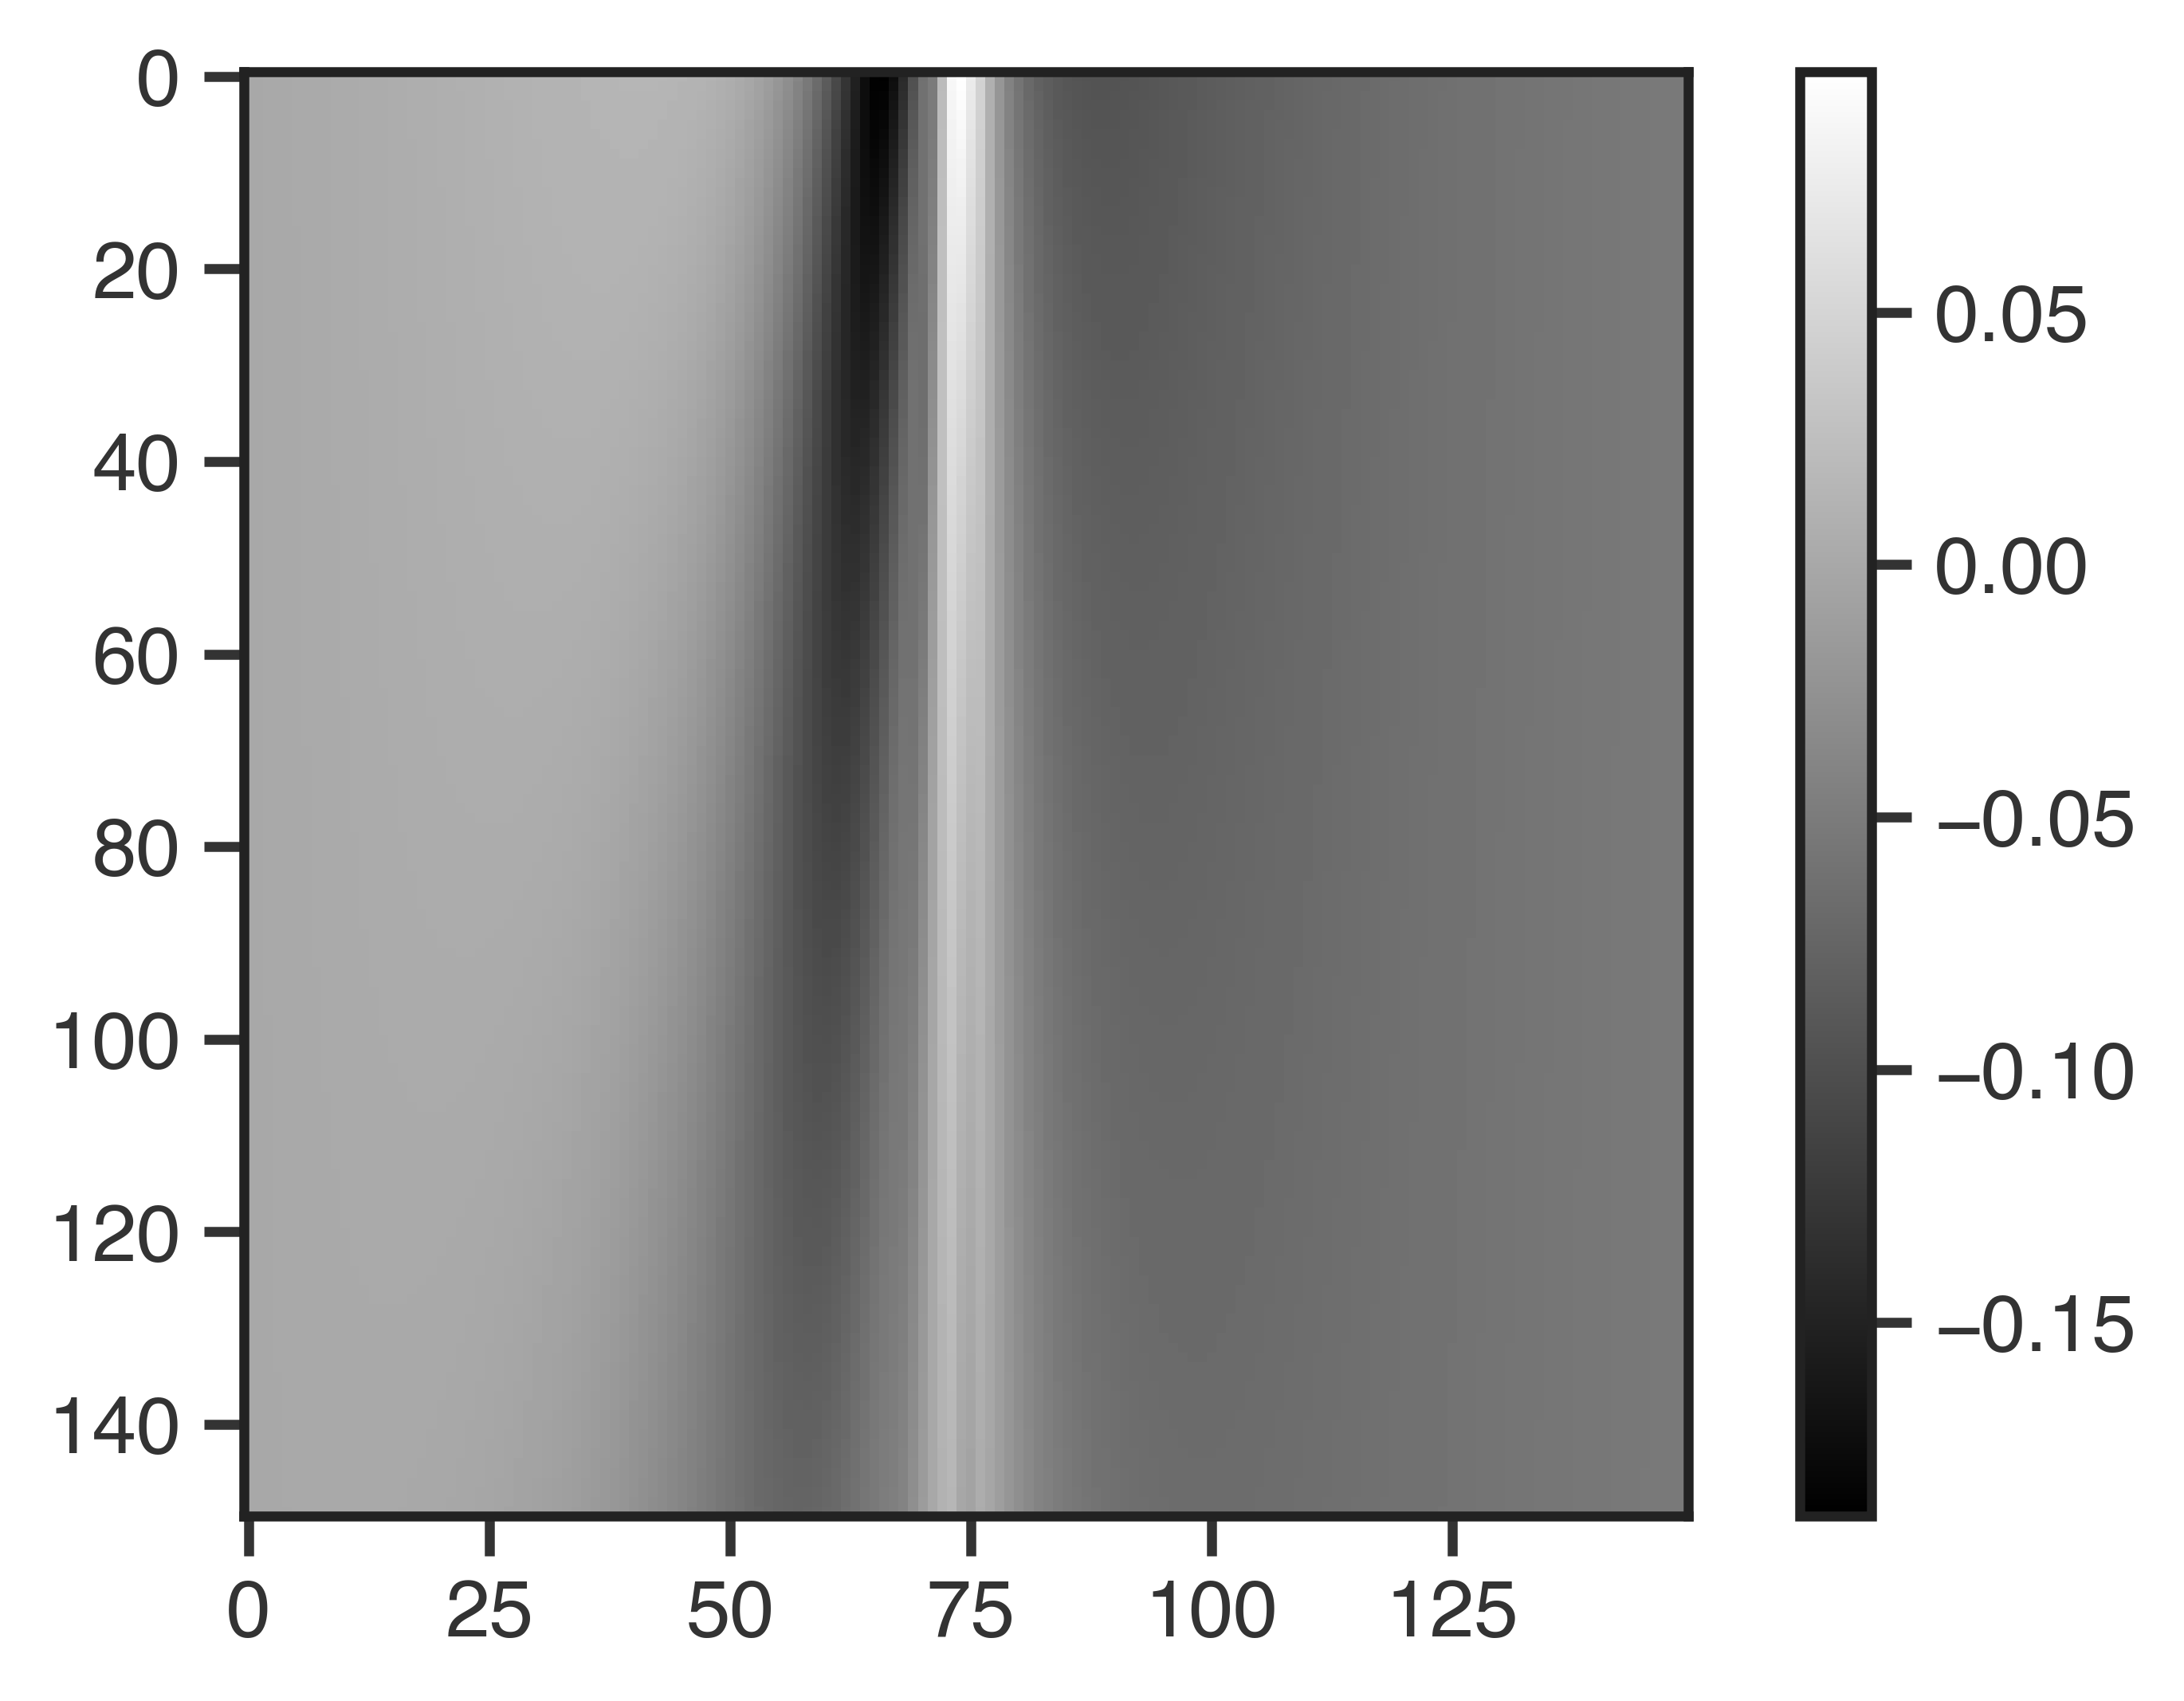

In [44]:
plt.imshow(info_maps['fast_off_adapting'] - info_maps['medium_off_adapting'])
plt.colorbar()

## Fit linear RF model to actual retinal ganglion cell receptive fields

In [45]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [ ]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    horz_weight = sigmoid(horz_weight)
    center_weight = sigmoid(center_weight)

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                # add regularization to ama_pos and horz_pos
                return sum(abs(normed_rf - rf)**2) + 0.05*(ama_pos**2 + horz_pos**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.randn(2)]),
                                    method='L-BFGS-B',
                                    bounds=[(1e-6,None), (np.min(space),np.max(space)), (np.min(space),np.max(space)),
                                           (np.min(space),np.max(space)), (None,None), (0,1)])
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # translate hw and cw params back into [0,1] range
            x = sigmoid(popt.x[-2:])

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)


0it [00:00, ?it/s]
6it [01:01, 10.33s/it]

In [ ]:
min_info = np.min(info_maps['medium_off_adapting'])
max_info = np.max(info_maps['medium_off_adapting'])

########## for quivers #########
all_fits = []
for celltype in fits.keys():
    all_fits.extend(fits[celltype])
    
pca = PCA(n_components=2)
pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.97*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])
    
average_least_info_direction = np.mean([least_info_directions[k] for k in least_info_directions.keys()], axis=0)
############ end quivers ###########

plt.imshow(info_maps['medium_off_adapting'], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
cbar.set_ticks([6,7,8,9])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=10, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
#     plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
#                adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
#                c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
          alpha=0.9)
plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)
plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# plt.savefig('Figures for Steve IV.png')

In [ ]:
fig = plt.gcf()
ax = plt.gca()

# Histogram
bin_edges = np.linspace(0, 1, 30)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(fits[celltype][:, 0], bins=bin_edges)
        ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')))
        prev_count += this_count
        
l = plt.legend(frameon=False, fontsize=9, loc='upper left')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

        

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('# Cells', color='k', fontsize=20)
ax.set_xlabel('Horizontal (1 - Amacrine) Weight')
# ax.set_ylim(0,300)
# ax.set_yticks([0,100,200,300])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_visible(False)

# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')



majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
# plt.savefig('1d y-axis distribution 3-2.png')

In [ ]:
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        plt.plot(center_weights, info_maps[celltype][75, :], alpha=0.8, color=colorscheme[celltype])
        infos_at_horz_slice = []
        center_weight_fits = np.stack(fits[celltype])[:, 1]
        for f in fits[celltype]:
            idx = np.argmin(abs(f[0] - horz_weights))
            idy = np.argmin(abs(f[1] - center_weights))
            infos_at_horz_slice.append(info_maps[celltype][idx, idy])

    #     color = np.random.rand(3)
        plt.scatter(center_weight_fits, infos_at_horz_slice, color=colorscheme[celltype], 
                    label=' '.join(celltype.split('_')), s=30, edgecolor='w', lw=0.5)
        plt.vlines(np.median(center_weight_fits), 0, 11, color=colorscheme[celltype], linestyle='--', alpha=0.8)
    
l = plt.legend(frameon=False, fontsize=9, loc='upper left')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

plt.ylabel('Information (bits)', fontsize=20)
# adjust_spines(plt.gca())
plt.ylim(0, 10)
plt.xlim(0,1.1)
ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.spines['bottom'].set_visible(False)
plt.xticks([])
ax1.set_xlabel('Center (1 - Surround) Weight', fontsize=20)

majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

# Histogram
bin_edges = np.linspace(0, 1, 50)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])

ax2 = ax1.twinx()
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(np.stack(fits[celltype])[:, 1], bins=bin_edges)
        ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5, edgecolor='k')
        prev_count += this_count

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_ylabel('# Cells', color='k', fontsize=20)
ax2.set_ylim(0,325)
ax2.set_yticks([0,100,200,300])

# ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
# plt.savefig('1d info slice with histogram with constrained noise rerun 1-21.png')

In [ ]:
fig = plt.gcf()
fig.set_size_inches((10,10))

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    #horz_weight = np.min([1.0, abs(horz_weight)])
#     first_pass = np.where(horz_weight > 1, 1-abs(horz_weight-1), abs(horz_weight))
#     horz_weight = np.where(first_pass > 1, 1-abs(first_pass-1), first_pass)
    horz_weight = sigmoid(horz_weight)

    center_weight = np.min([1.0, abs(center_weight)])

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in real_fits.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                'medium_off_adapting', 'slow_off']:
        plt.clf()
        count = 0
        sorted_rf_ids = [x for (y,x) in sorted(zip(fits[celltype][:,0],
                                                  np.arange(fits[celltype].shape[0])))]
        for i,idf in enumerate(sorted_rf_ids):
            plt.subplot(10,4, count % 40 + 1)
            
            rf = unduplicated_receptive_fields[celltype][idf]
            modeled_rf = rf_model(*all_params[celltype][idf])
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            
            plt.plot(space, rf, 'k')
            plt.plot(space, normed_rf, 'r', linewidth=1)
            
            # plot components
            norm_factor = np.max(abs(rf))/np.max(abs(modeled_rf))
            width, mean, ama_pos, horz_pos, hw, cw = all_params[celltype][idf]
            hw = sigmoid(hw)
            cw = np.min([1.0, abs(cw)])
            center = gaussian(x=space, sigma=abs(width), mu=mean)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
            new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
            new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
            ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
            horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))
            
            plt.plot(space, norm_factor*cw*center, 'c', linewidth=1)
            plt.plot(space, norm_factor*(1.-cw)*hw*horz, 'g', linewidth=1)
            plt.plot(space, norm_factor*(1.-cw)*(1.-hw)*ama, 'b', linewidth=1)
            
            plt.text(-40, 0.1, '%d' %idf, fontsize=8)
            plt.text(-40, -0.5, 'hw = %0.2f' %real_fits[celltype][idf][0], fontsize=8)
            adjust_spines(plt.gca())
            count += 1

            if count % 40 == 0:
                if count >= 40:
                    page_num = int(count/40)
                    plt.savefig('%s rfs page %d.png' %(celltype, page_num))
                    plt.clf()
    